In [2]:
%pip install yfinance pandas numpy matplotlib
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [27]:
tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
short_window = 50
long_window = 200
initial_capital = 100000.0

In [28]:
def moving_average_crossover(stock_data):
    stock_data['SMA50'] = stock_data['Close'].rolling(window=short_window, min_periods=1).mean()
    stock_data['SMA200'] = stock_data['Close'].rolling(window=long_window, min_periods=1).mean()
    
    # Buy signal: when the short-term SMA crosses above the long-term SMA
    stock_data['Signal'] = 0
    stock_data['Signal'][short_window:] = \
        [1 if stock_data['SMA50'].iloc[i] > stock_data['SMA200'].iloc[i] else 0 for i in range(short_window, len(stock_data))]
    
    # position: 1 means holding the stock, 0 means not holding
    stock_data['Position'] = stock_data['Signal'].diff()
    
    return stock_data

In [30]:
def backtest(stock_data):
    stock_data = moving_average_crossover(stock_data)
    stock_data['Portfolio Value'] = initial_capital
    
    in_position = False
    shares = 0
    cash = initial_capital
    
    for i in range(len(stock_data)):
        if stock_data['Position'].iloc[i] == 1 and not in_position:  # Buy signal
            shares = cash // stock_data['Close'].iloc[i]
            cash -= shares * stock_data['Close'].iloc[i]
            in_position = True
        
        elif stock_data['Position'].iloc[i] == -1 and in_position:  # Sell signal
            cash += shares * stock_data['Close'].iloc[i]
            shares = 0
            in_position = False
        
        # Update portfolio value
        stock_data['Portfolio Value'].iloc[i] = cash + shares * stock_data['Close'].iloc[i]
    
    # Final portfolio value
    final_portfolio_value = cash + shares * stock_data['Close'].iloc[-1]
    return final_portfolio_value


In [34]:
results = {}
for ticker in tech_stocks:
    stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
    final_value = backtest(stock_data)
    results[ticker] = final_value

results_df = pd.DataFrame(list(results.items()), columns=['Ticker', 'Final Portfolio Value'])
results_df['Strategy Return (%)'] = (results_df['Final Portfolio Value'] - initial_capital) / initial_capital * 100
average_strategy_return = results_df['Strategy Return (%)'].mean()
sp500_data = yf.download("SPY", start='2020-01-01', end='2024-01-01')
sp500_return = (sp500_data['Close'].iloc[-1] - sp500_data['Close'].iloc[0]) / sp500_data['Close'].iloc[0] * 100
print("SMA Crossover Strategy Results:")
print(results_df)
print(f"\nAverage Strategy Return: {average_strategy_return:.2f}%")
print(f"S&P 500 Return over the same period: {sp500_return:.2f}%")


[*********************100%%**********************]  1 of 1 completed
C:\Users\ashda\AppData\Local\Temp\ipykernel_39028\3261282993.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  stock_data['Signal'][short_window:] = \
C:\Users\ashda\AppD

SMA Crossover Strategy Results:
  Ticker  Final Portfolio Value  Strategy Return (%)
0   AAPL          170585.127331            70.585127
1   MSFT          275289.129547           175.289130
2  GOOGL          243304.065033           143.304065
3   AMZN          203661.071198           103.661071
4   TSLA          592605.073204           492.605073

Average Strategy Return: 197.09%
S&P 500 Return over the same period: 46.31%


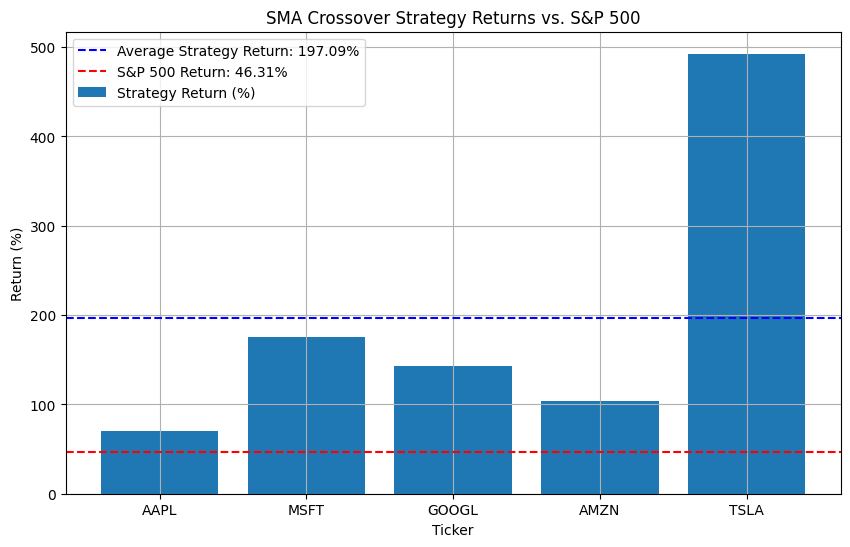

In [35]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Ticker'], results_df['Strategy Return (%)'], label='Strategy Return (%)')
plt.axhline(average_strategy_return, color='blue', linestyle='--', label=f'Average Strategy Return: {average_strategy_return:.2f}%')
plt.axhline(sp500_return, color='red', linestyle='--', label=f'S&P 500 Return: {sp500_return:.2f}%')
plt.title("SMA Crossover Strategy Returns vs. S&P 500")
plt.xlabel("Ticker")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True)
plt.show()